In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import math
import keras
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.utils import class_weight
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.models import load_model
import joblib
# import py_vollib.black_scholes.implied_volatility
import multiprocessing
from multiprocessing import Pool
import os
# import py_vollib.black_scholes.implied_volatility as vb
%matplotlib inline

Using TensorFlow backend.
/home/sharan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sharan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sharan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sharan/anaconda3/lib/python3.6/site-packages/tenso

In [3]:
keras.__version__

'2.2.4'

In [2]:
# Path settings


path_var = 2 

if (path_var == 1):
    filepath = '/home/docboy/Desktop/Option_Pricing/datasets/'
    modelpath = '/home/docboy/Desktop/Option_Pricing/pickles/'


else:
    filepath = '/home/sharan/Desktop/OptionPricing-master/datasets/'
    modelpath = '/home/sharan/Desktop/OptionPricing-master/pickles/'



nfty = filepath + 'NIFTY50_feature_set_COV_complete.csv'
nfty_ecdf = filepath + 'NIFTY50_feature_set_ECDF_complete.csv'
    
bnfty = filepath + 'BANKNIFTY_feature_set_COV_complete.csv'
bnfty_ecdf = filepath + 'BANKNIFTY_feature_set_ECDF_complete.csv'


In [3]:
# Set the automated variables + Plus drop all useless columns approach specific


###########################
###############################################

approach = 3                     #------------------>>> # Change value as needed

###############################################
###########################


if (approach == 1):
    n_feats = pd.read_csv(nfty_ecdf)
    print ('Approach var set to ECDF')
    
    dropNames = ['date', 'percentage','strike','spot','opPrice']
    
    b_feats = pd.read_csv(bnfty_ecdf)
    
else:
    n_feats = pd.read_csv(nfty)
    print ('Approach var set to :: '+ str(approach))
    
    b_feats = pd.read_csv(bnfty)
    
    if (approach == 2):
        dropNames= ['date', 'percentage','strike','spot','opPrice','change_oi','ts_atr','prevOp','avg_atmError']
        
    else:
        dropNames= ['date', 'percentage','strike','spot','opPrice','ts_atr','change_oi']
        
###################
  

Approach var set to :: 3


In [4]:
n_feats = n_feats.drop(dropNames, axis = 1)
b_feats = b_feats.drop(dropNames, axis = 1)

In [5]:
diff = len(b_feats)-len(n_feats)
b_feats = b_feats.iloc[diff:, :]
b_feats = b_feats.reset_index(drop=True)

In [6]:

feats = n_feats.append(b_feats, ignore_index=True)

X=feats.iloc[:,:-1]
Y=feats.loc[:,'Target']  

In [7]:
featNames = list(X)  
scaler = RobustScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns = featNames)

onehot = OneHotEncoder(sparse=False)
Y = Y.values
Y = Y.reshape(len(Y), 1)
onehot.fit(Y)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [8]:
# Split the train and test sets without random optimizations


a = len(n_feats)
split_val = round(a*0.8)

# Removing the Random splits

Ntrain = n_feats.iloc[0:split_val, :]
Ntest = n_feats.iloc[split_val:, :]

b = len(b_feats)
split_val = round(b*0.8)

# Removing the Random splits

Btrain = b_feats.iloc[0:split_val, :]
Btest = b_feats.iloc[split_val:, :]


train = Ntrain.append(Btrain, ignore_index=True)

train = train.sample(frac=1).reset_index(drop=True)

test = Ntest.append(Btest, ignore_index=True)

test = test.sample(frac=1).reset_index(drop=True)

X_train=train.iloc[:,:-1]
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns = featNames)
Y_train=train.loc[:,'Target']
Y_train = Y_train.values
Y_train = Y_train.reshape(len(Y_train), 1)
Y_train = onehot.transform(Y_train)

X_test=test.iloc[:,:-1]
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = featNames)
Y_test=test.loc[:,'Target']
Y_test = Y_test.values
Y_test = Y_test.reshape(len(Y_test), 1)
Y_test = onehot.transform(Y_test)

print ('X & Y_Dim of Train is', X_train.shape, Y_train.shape)
print ('X & Y_Dim of Test is', X_test.shape, Y_test.shape)

X & Y_Dim of Train is (21626, 19) (21626, 50)
X & Y_Dim of Test is (5406, 19) (5406, 50)


In [9]:
opt=optimizers.Adam(lr=0.00012);
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=128, activation='relu',input_dim=X_train.shape[1]))
# model.add(keras.layers.Dropout(0.5))
# model.add(keras.layers.Dense(units=128, activation='relu'))
# model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(units=64, activation='relu'))
# model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(units=50, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],)
history=model.fit(X_train, Y_train,
  batch_size=32,
  epochs=45,
  verbose=1,
#   class_weight=class_weights,
  validation_data=(X_test, Y_test),
  shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2560      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3250      
Total params: 14,066
Trainable params: 14,066
Non-trainable params: 0
_________________________________________________________________
Train on 21626 samples, validate on 5406 samples
Epoch 1/45
21626/21626 [==============================] - 2s 99us/step - loss: 3.6634 - acc: 0.0672 - val_loss: 3.3195 - val_acc: 0.0810
Epoch 2/45
21626/21626 [==============================] - 1s 65us/step - loss: 3.1506 - acc: 0.0976 - val_loss: 2.9516 - val_acc: 0.1080
Epoch 3/45
21626/21626 [==============================] - 2s 84us/step - loss: 

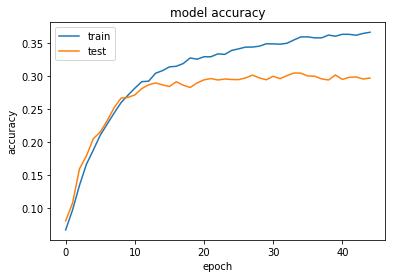

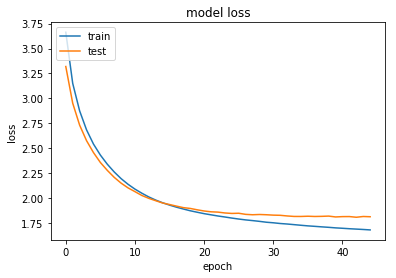

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1]*100)

Y_pred=model.predict(X_test)
Y_pred=np.argmax(Y_pred,axis=1)

Test accuracy: 29.67073622452873


In [12]:
OGY_test=onehot.inverse_transform(Y_test)
# OGY_test=sum(OGY_test, [])
OGY_test=OGY_test.ravel()
# print(OGY_test)

# # Check if Binwidth value exists
maxVal=5
minVal=0

width = maxVal - minVal

num_bins = 50


bin_width = width/num_bins
# print(bin_width)

# Normalized Error Metric (NEM)

dist_sum = 0
for i in range(len(Y_pred)):
    dist = abs(Y_pred[i] - OGY_test[i])
    dist_sum = dist_sum + dist
    
print((dist_sum*bin_width)/len(Y_test))

0.13375878653348133


# Testing BNF+NF on NF and BNF separately 

In [13]:
nf_Ytest = Ntest.loc[:, 'Target']
nf_Xtest = Ntest.iloc[:, :-1]

featNames = list(nf_Xtest)

nf_Xtest = scaler.transform(nf_Xtest)
# nf_Ytest = onehot.transform(nf_Ytest)

nf_Xtest = pd.DataFrame(nf_Xtest, columns = featNames)


pred = model.predict(nf_Xtest)

pred = np.argmax(pred,axis=1)

nf_Ytest=nf_Ytest.tolist()

dist_sum = 0
for i in range(len(pred)):
    dist = abs(pred[i] - nf_Ytest[i])
    dist_sum = dist_sum + dist
    
print("NEM ::", (dist_sum*bin_width)/len(nf_Ytest))


NEM :: 0.12489826119126897


In [14]:
## BNF


bnf_Ytest = Btest.loc[:, 'Target']
bnf_Xtest = Btest.iloc[:, :-1]

featNames = list(bnf_Xtest)

bnf_Xtest = scaler.transform(bnf_Xtest)
# bnf_Ytest = onehot.transform(bnf_Ytest)

bnf_Xtest = pd.DataFrame(bnf_Xtest, columns = featNames)


pred = model.predict(bnf_Xtest)

pred = np.argmax(pred,axis=1)

bnf_Ytest=bnf_Ytest.tolist()

dist_sum = 0
for i in range(len(pred)):
    dist = abs(pred[i] - bnf_Ytest[i])
    dist_sum = dist_sum + dist
    
print("NEM ::", (dist_sum*bin_width)/len(bnf_Ytest))


NEM :: 0.14261931187569368
